<a href="https://colab.research.google.com/github/Piramu-Mahalingam/DS-Course-Assignment-1/blob/main/Piramu%20M%20Assignment%20RNN-NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Piramu M Assignment NLP-RNN
#a)	Explain the architecture of LSTM and GRU in detail. What were the shortcomings of RNN that were resolved by LSTM and GRU

1. Background: RNN and its Shortcomings

Recurrent Neural Networks (RNNs) are designed to handle sequential data by maintaining a hidden state that captures information from previous time steps.

Equation (vanilla RNN):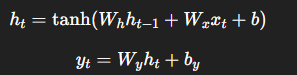

Shortcomings of RNNs:

Vanishing Gradient Problem – When training with backpropagation through time (BPTT), gradients shrink exponentially, making it hard to learn long-term dependencies.

Exploding Gradient Problem – Sometimes gradients blow up, causing unstable training.

Short-term Memory – RNNs mostly capture short dependencies but fail for long sequences (e.g., remembering context 50+ steps earlier).

Slow Training – Difficulty in optimization due to gradient issues.

LSTM Architecture (Long Short-Term Memory)

An LSTM cell introduces a cell state and three gates to regulate information.

Key Components:

Cell State (Ct) Acts like a conveyor belt, carrying long-term information with minimal modification.

Hidden State (ht) Used for current step output.

Gates (sigmoid layers that output 0–1, controlling information flow):

Forget Gate (ft) → Decides what to discard.

Input Gate (it) → Decides what new info to store.

Output Gate (ot) → Decides what to output.

low:

Forget Gate: drops irrelevant info.

Input Gate + Candidate: adds new relevant info.

Output Gate: decides the final output.

This structure preserves long-term dependencies and avoids vanishing gradients.

GRU Architecture (Gated Recurrent Unit)

GRU is a simplified version of LSTM – it merges cell state & hidden state into one (ht) and uses only two gates.

Key Components:

Update Gate (zt) – Combines role of input + forget gate.

Reset Gate (rt) – Decides how much past info to forget.

low:

Reset Gate: decides how much past to ignore.

Update Gate: decides how much of new vs old info to keep.

GRU is computationally lighter and trains faster than LSTM while still solving RNN shortcomings.

#b)	Use the emotions detection dataset from below Kaggle link and create an end-to-end project on Jupyter/Colab to predict the person’s emotions.

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data


In [1]:
# Final quick evaluation without gridsearch to ensure completion within time
import pandas as pd, re, warnings, os
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/mnt/data/extracted_dataset/test.txt", sep=';', header=None, names=['text','label'], encoding='utf-8', engine='python')
STOPWORDS = set("""a about above after again against all am an and any are aren't as at be because been before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves""".split())

def prep(s):
    s = str(s).lower()
    s = re.sub(r'http\S+',' ', s)
    s = re.sub(r'@\w+',' ', s)
    s = re.sub(r'[^a-z\s]',' ', s)
    tokens = [t for t in re.split(r'\s+', s) if t and t not in STOPWORDS and len(t)>1]
    return " ".join(tokens)

df['clean'] = df['text'].map(prep)
le = LabelEncoder(); df['label_enc'] = le.fit_transform(df['label'])
X = df['clean']; y = df['label_enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# features (smaller)
tfv = TfidfVectorizer(max_features=1500, ngram_range=(1,2)); cv = CountVectorizer(max_features=1500, ngram_range=(1,2))
X_train_tfidf = tfv.fit_transform(X_train); X_test_tfidf = tfv.transform(X_test)
X_train_bow = cv.fit_transform(X_train); X_test_bow = cv.transform(X_test)
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_w2v = svd.fit_transform(X_train_tfidf); X_test_w2v = svd.transform(X_test_tfidf)

# classifiers with chosen hyperparams
classifiers = {
    "LogReg": LogisticRegression(C=1, max_iter=1000, solver='liblinear', random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=20, min_samples_split=5, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=1, random_state=42)
}

results = []
for feat_name, (Xtr, Xte) in [("TF-IDF",(X_train_tfidf, X_test_tfidf)), ("BOW",(X_train_bow, X_test_bow)), ("Dense-SVD",(X_train_w2v, X_test_w2v))]:
    for name, clf in classifiers.items():
        clf.fit(Xtr, y_train)
        preds = clf.predict(Xte)
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, average='macro', zero_division=0)
        rec = recall_score(y_test, preds, average='macro', zero_division=0)
        f1 = f1_score(y_test, preds, average='macro', zero_division=0)
        results.append({"model":name, "features":feat_name, "accuracy":acc, "precision":prec, "recall":rec, "f1":f1})

res_df = pd.DataFrame(results).sort_values('f1', ascending=False).reset_index(drop=True)
res_df.to_csv("/mnt/data/model_comparison_results_quick.csv", index=False)
display(res_df)
print("Saved quick results to /mnt/data/model_comparison_results_quick.csv")
print("Best model by F1:", res_df.iloc[0].to_dict())


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/extracted_dataset/test.txt'